In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

import wandb

In [2]:
# setup
# Paths to data splits
TRAIN_DIR = "../data/train"
VAL_DIR = "../data/val"
TEST_DIR = "../data/test"

# Image parameters
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 10

# Number of classes (will detect automatically)
classes = os.listdir(TRAIN_DIR)
NUM_CLASSES = len(classes)

print(f"Detected classes: {classes}")

Detected classes: ['normal', 'yawn']


Found 1890 images belonging to 2 classes.
Found 405 images belonging to 2 classes.
Found 407 images belonging to 2 classes.


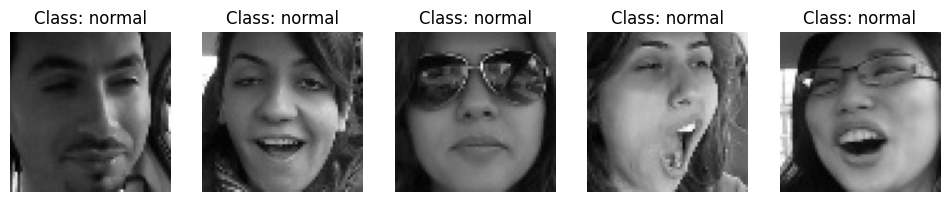

In [3]:
# Load images with ImageDataGenerator

# just rescale
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# Preview a few images
x_batch, y_batch = next(train_generator)

fig, axes = plt.subplots(1, 5, figsize=(12,3))
for i in range(5):
    axes[i].imshow(x_batch[i].reshape(IMG_SIZE), cmap='gray')
    axes[i].set_title(f"Class: {classes[np.argmax(y_batch[i])]}")
    axes[i].axis('off')
plt.show()


In [4]:

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # single output neuron for binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()


d:\SPU\Lectures\y5_s1\Junior Project\code\mediapipe_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,753 (2.60 MB)

 Trainable params: 682,753 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
wandb.login()

wandb: Currently logged in as: omarhariri (omarhariri-syrian-private-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
wandb.init(
    project="driver-drowsiness",
    name="cnn_v1",
    config={
        "img_size": IMG_SIZE,
        "batch_size": BATCH_SIZE,
        "epochs": 10,
        "optimizer": "Adam",
        "learning_rate": 1e-4,
        "architecture": "CNN_v1"
    }
)

In [8]:
from wandb.integration.keras import WandbMetricsLogger
wandb_metrics = WandbMetricsLogger()

callbacks = [
    wandb_metrics
]

In [9]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = callbacks
)


d:\SPU\Lectures\y5_s1\Junior Project\code\mediapipe_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 376ms/step - accuracy: 0.7305 - loss: 0.6055 - val_accuracy: 0.7358 - val_loss: 0.4781
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.8247 - loss: 0.4075 - val_accuracy: 0.8716 - val_loss: 0.3538
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 347ms/step - accuracy: 0.8950 - loss: 0.3233 - val_accuracy: 0.8889 - val_loss: 0.3281
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 349ms/step - accuracy: 0.8997 - loss: 0.2787 - val_accuracy: 0.9111 - val_loss: 0.2965
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 373ms/step - accuracy: 0.9031 - loss: 0.2846 - val_accuracy: 0.8938 - val_loss: 0.3133
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 365ms/step - accuracy: 0.9078 - loss: 0.2869 - val_accuracy: 0.9086 - val_loss: 0.3062
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 364ms/step - accuracy: 0.9165 - loss: 0.2413 - val_accuracy: 0.9037 - val_loss: 0.2966
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9087 - loss: 0.2506 - val_accu

In [10]:
# Evaluate model on test set and compute F1 score precision and recall

# Predict on test set
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)  # threshold 0.5 for binary
y_true = test_generator.classes  # true labels

test_accuracy = np.mean(y_pred == y_true)
print(f"test accuracy on test set: {test_accuracy:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 555ms/step
test accuracy on test set: 0.9361


In [11]:
test_loss, test_acc = model.evaluate(test_generator)
wandb.log({
    "test_loss": test_loss,
    "test_accuracy": test_acc
})

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9691 - loss: 0.1694


In [12]:
#  full classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))



Classification Report:
              precision    recall  f1-score   support

      normal       0.94      0.98      0.96       297
        yawn       0.93      0.83      0.88       110

    accuracy                           0.94       407
   macro avg       0.93      0.90      0.92       407
weighted avg       0.94      0.94      0.93       407



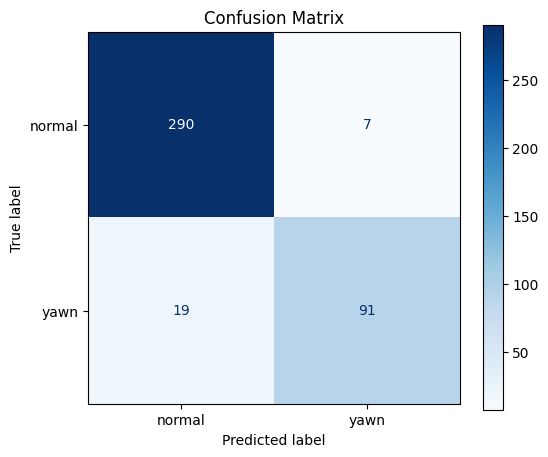

In [13]:
# Plot confusion matrix 

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


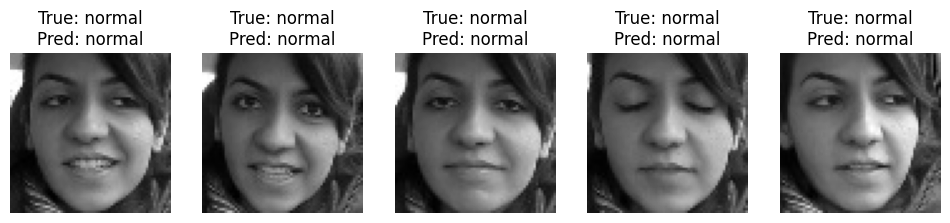

In [14]:
# Sample Predictions – display test images with predicted vs true labels
x_test, y_test = next(test_generator)  # batch from test generator
y_pred_sample = (model.predict(x_test) > 0.5).astype(int).reshape(-1)

# Convert true labels to integers
y_test_int = y_test.astype(int)

fig, axes = plt.subplots(1, 5, figsize=(12,3))
for i in range(5):
    axes[i].imshow(x_test[i].reshape(IMG_SIZE), cmap='gray')
    axes[i].set_title(f"True: {classes[y_test_int[i]]}\nPred: {classes[y_pred_sample[i]]}")
    axes[i].axis('off')
plt.show()


In [16]:
# Save the model (architecture + weights + optimizer state)
model.save("../models/cnn_v1/model.keras")

In [17]:
with open("../models/cnn_v1/history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [18]:
wandb.finish()

epoch/accuracy,▁▆▇▇▇█▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▁▁▁
epoch/val_accuracy,▁▆▇█▇█▇█▇▇
epoch/val_loss,█▃▂▁▂▂▁▁▁▂
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.92434
epoch/epoch,9
epoch/learning_rate,0.001
